# 2D slice of a waveguide, TM-modes


To calculate the resonant frequencies of an infinitely long, empty, and uniform rectangular waveguide, we will construct a simple computational cell in Meep and surround it with a perfect electrical conducting (PEC) boundary. We will also take a look at the phase of the electric field and an animation of the time-varying field. Lastly, we will show an example of how of you can write a step function in Meep to look at the maximum value of a periodic field.

This particular type of waveguide only supports two different types of modes, commonly referred to as Transverse Magnetic (TM) and Transverse Electric (TE). For a waveguide of dimensions $s_x, s_y,$ the analytical expression for the resonant frequencies of both TM and TE modes is given by

$$f_{nm}(s_x, s_y)=\frac{1}{2}\sqrt{\frac{m}{s_x}^2+\frac{n}{s_y}^2},$$

where in the case of TM modes, both $n$ and $m$ are positive non-zero integers.


The imports that we will use are

In [124]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from scipy import constants as con

Next, let us define a couple of functions that we will make use of later. The first function is the theoretical expression for the TM frequency expressed in meep units. Meep uses dimensionless units where $c=\mu_0=\varepsilon_0=1,$ and you can choose which base you wish to define distances in. So if we wish to construct a waveguide where e.g. $s_x$ is in the millimeter range, we can set the base unit accordingly. The other two functions are for converting between SI and Meep units. 

In [125]:
def TM_mode_SI(n, m, s_x, s_y):
    """Transverse magnetic mode, empty rectangular waveguide with PEC walls."""

    if n == 0 or m == 0:
        raise ValueError("Unsupported input parameter")
    else:
        mode = 0.5*np.sqrt((n/s_x)**2+(m/s_y)**2)
        return mode


def frequency_SI_to_MP(x, meep_unit):

    return (x*meep_unit)/con.c


def frequency_MP_to_SI(x, meep_unit):

    return (x*con.c)/meep_unit

    
meep_unit = 1e-3

We also need to set the resolution (number of pixels per unit distance) of the simulation. One should keep in mind that increasing the resolution also increases the number of time steps in a simulation. For this particular setup, we will not be concerned with finer details such as the e.g. the skin depth of a conductor, so a low resolution should be enough.   

In [126]:
resolution = 20

Next, we set the size of the computational cell, which in Meep is done through a geometric object Vector3. Since the walls of our waveguide will be implemented through a PEC boundary, the size of the waveguide and the cell will be the same. 

In [127]:
s_x = 1.2
s_y = 1.
cell_size = mp.Vector3(s_x, s_y, 0)

To extract the resonant modes we need to excite the electric field in the z-direction, we can do this by placing a Gaussian current source inside the waveguide. Current sources in Meep are labeled by field components, the i:te components of field A is defined as Ai, so we specify the field component of our source as mp.Ez.

The source will excite modes within the frequency range of $f\pm\frac{df}{2}$. (Or is it not half?!) Keep in mind that where we put the source may affect which types of modes (w.r.p. their symmetry) that are excited, and it may also prevent us from reducing the computational time by invoking symmetries.

In [128]:
source_frequency = 1.47
source_frequency_width = 0.2*source_frequency
source = mp.Source(mp.GaussianSource(frequency=source_frequency,
                                     fwidth=source_frequency_width),
                                     component=mp.Ez,
                                     center=0.05*mp.Vector3(s_x, s_y),
                                     size=mp.Vector3())

The actual computations that we will run are controlled by the simulation object, our setup is pretty simple so we only specify the size of the computational cell, our source and the resolution. Since we have not specified a k_point, the default boundary condition is a PEC.

In [129]:
sim = mp.Simulation(cell_size=cell_size, sources=[source], resolution=resolution)

To compute the resonant frequencies, we will use the step function [Harminv](https://github.com/NanoComp/harminv). It seems to work best when you are computing just a few modes within a narrow frequency range, so it's good if you have a pretty good idea of what you are looking for. To use it, we need to specify which field component (c) to analyze, in which point (pt) to gather information for analysis, and in which frequency range it should look for resonant modes. There are a couple of things that could be worth mentioning:
> * On one hand the computational error becomes less if you use a narrow frequency range. On the other hand, this will increase your simulation time.
> * Where you choose to sample may matter. If you are unlucky and hit a node, you might not find it.

Later on, we will add the step function h_ to the simulation.

In [130]:
sample_point = 0.3*mp.Vector3(s_x, s_y)
h_ = mp.Harminv(c=mp.Ez, pt=sample_point, fcen=source_frequency, df=source_frequency_width)

To see the geometry of the simulation, you can use the command sim.plot2D(). Any sources will be shown in red.

-----------
Initializing structure...
time for choose_chunkdivision = 5.96046e-06 s
Working in 2D dimensions.
Computational cell is 1.2 x 1 x 0 with resolution 20
time for set_epsilon = 0.000861883 s
-----------


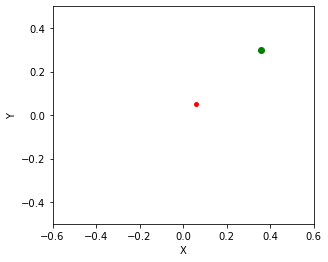

In [131]:
sim.plot2D()
plt.scatter(sample_point[0], sample_point[1], color="g")
plt.show()

Now that we've set up the geometry, sources, and which step function to use, we can start the simulation by using the run function. There are some convenient ways to control the run time of your simulation, e.g. you can let it run until a certain condition is met. For now, we will just let it run 100 time steps after the source has been turned off. We also need to make sure that Harminv isn't executed until the sources have been turned off, we do this by wrapping it in mp.after_sources().  

Executing the cell below will run the simulation. If you haven't changed any settings, it should finish in a couple of seconds and print three resonant modes that Harminv has found.

In [132]:
until_after_sources = 100
sim.run(mp.after_sources(h_), until_after_sources=until_after_sources)

FloatProgress(value=0.0, description='0% done ', max=134.01360702514648)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 1.3411378063757715, 3.3841139421932276e-06, -198151.98738648064, 0.070349145544566, 0.03789611459689653+0.05926961090904358i, 5.75406189062416e-07+0.0i
harminv0:, 1.5471892195173855, -3.1032085398954533e-09, 249288631.36756998, 0.9457514693044591, -0.5542629232341324-0.7663148527984418i, 1.1331812984242064e-07+0.0i
harminv0:, 1.5961252524642253, 1.487235965544211e-05, -53660.79389695802, 0.049578702868221546, 0.02006382163234733-0.04533752132175678i, 2.61591595376731e-06+0.0i
run 0 finished at t = 134.025 (5361 timesteps)


Lets extract the frequencies from Harminv and compare them to the analytical expression.

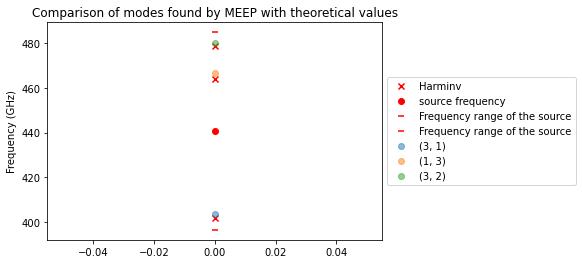

In [133]:
plt.title("Comparison of modes found by MEEP with theoretical values")
freqs = frequency_MP_to_SI(np.asarray([m.freq for m in h_.modes]), meep_unit)
plt.scatter([0, 0, 0], freqs*1e-9, color="r", marker="x", label="Harminv")

freqs_theory = [(3, 1), (1, 3), (3, 2)]

plt.scatter(0, frequency_MP_to_SI(source_frequency, meep_unit)*1e-9, color="r",
            label="source frequency")
for s in [-1, 1]:
    plt.scatter(0, frequency_MP_to_SI(source_frequency+s*0.5*source_frequency_width, meep_unit)*1e-9,
                color="r", marker="_", label="Frequency range of the source")
for mode in freqs_theory:
    plt.scatter(0, frequency_MP_to_SI(TM_mode_SI(mode[0], mode[1], s_x, s_y)*1e-9, meep_unit),
                alpha=0.5, label=str(mode))

plt.ylabel("Frequency (GHz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can also take a look at the field distribution of a specific mode, e.g. the $TM_{13}$ mode. We change the width of the source and make a new simulation covering a narrower frequency range. By default the simulation will try to use real fields, but this time we will want to take a look at the phase of $E_z,$ so we force specify that it should complex fields.

In [134]:
sim.reset_meep()

source_frequency = [m.freq for m in h_.modes][1]
source_frequency_width = 0.01*source_frequency
source = mp.Source(mp.GaussianSource(frequency=source_frequency,
                                     fwidth=source_frequency_width),
                                     component=mp.Ez,
                                     center=0.05*mp.Vector3(s_x, s_y),
                                     size=mp.Vector3())
sim = mp.Simulation(cell_size=cell_size, sources=[source], resolution=resolution,
                    force_complex_fields=True)

h_ = mp.Harminv(c=mp.Ez, pt=sample_point, fcen=source_frequency, df=source_frequency_width)
sim.run(mp.after_sources(h_), until_after_sources=until_after_sources)
frequency = [m.freq for m in h_.modes][0]

-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-06 s
Working in 2D dimensions.
Computational cell is 1.2 x 1 x 0 with resolution 20
time for set_epsilon = 0.000473022 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=746.3333740234375)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 1.5471884540775402, 5.686690412450699e-11, -13603593143.474588, 133.13730244453112, 127.88720000188611-37.018986721466774i, 1.5133811685375864e-13+0.0i
run 0 finished at t = 746.35 (29854 timesteps)


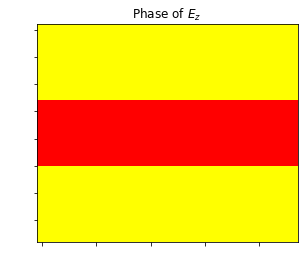

In [135]:
phase = np.angle(sim.get_array(component=mp.Ez, cmplx=True))

plt.title(r"Phase of $E_z$")
plt.imshow(phase.T, cmap="autumn")
plt.xticks(color="w")
plt.yticks(color="w")
plt.show()

You can also take a look at the animation of the $E_z$ field, as our walls are perfect conductors we expect that particular field to be zero all along the border. Field components in Meep are constants (i.e. str(mp.Ez)=4), which can come in handy when saving some output. Run the cell below to save and look at a video of the $E_z$ field consisting of $40$ time slices taken during one period. 

Since our source used the component $E_z,$ the other non-zero fields are $H_x, H_y.$ Change the field variable below if you'd rather take a look at one of those.

In [136]:
def animate_field(field, n_slices, time_steps):
    
    animate = mp.Animate2D(sim, fields=field, f=plt.figure(dpi=150),
                           realtime=False, normalize=True)
    sim.run(mp.at_every(time_steps/n_slices, animate), until=time_steps)
    plt.close()
    fps = 5
    filename = str(field)+".mp4"
    animate.to_mp4(fps, filename )

field = mp.Ez
animate_field(field, 40, 1/frequency)
Video(str(field)+".mp4")

FloatProgress(value=746.3499755859375, description='0% done ', max=746.9963092612985, min=746.3499755859375)

Normalizing field data...
run 1 finished at t = 747.0 (29880 timesteps)
Generating MP4...


You can also look at images of the field. For example, if you wanted to output single time slices of the $H_x$ field, you could e.g. use:
sim.run(mp.at_every(until/slices, mp.output_png(mp.Hx, "-Zc dkbluered")), until=0.25/frequency)

If you are more interested in looking at e.g. the maximum field value during some period, you can write a step function.

-----------
Initializing structure...
time for choose_chunkdivision = 5.00679e-06 s
Working in 2D dimensions.
Computational cell is 1.2 x 1 x 0 with resolution 20
time for set_epsilon = 0.00050211 s
-----------


FloatProgress(value=0.0, description='0% done ', max=746.3333740234375)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 1.54719225925973, 1.006937422411386e-05, -76826.63414944678, 66.35840508060545, 63.76353883311071-18.375228986875413i, 1.6742544767308027e-06+0.0i
run 0 finished at t = 746.35 (29854 timesteps)


FloatProgress(value=746.3499755859375, description='0% done ', max=746.6731416288178, min=746.3499755859375)

run 1 finished at t = 746.6750000000001 (29867 timesteps)


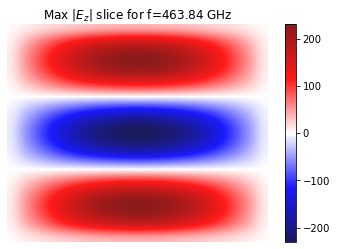

In [139]:
def get_max_field_slice_2D(sim, frequency):

    def get_max_field_slice(sim):

        field_new = sim.get_efield_z()
        field_new_set = [field_new, np.max(np.abs(field_new))]
        if field_old_set[1] < field_new_set[1]:
            field_old_set[0] = field_new_set[0]
            field_old_set[1] = field_new_set[1]

    until = 0.5/frequency
    slices = 10
    field_old = sim.get_efield_z()
    field_old_set = [field_old, np.max(np.abs(field_old))]
    eps_data = sim.get_array(size=cell_size,
                             center=mp.Vector3(0, 0, 0),
                             component=mp.Dielectric)

    sim.run(mp.at_every(until/slices, get_max_field_slice), until=until)
    max_field = field_old_set[0]
    
    freq_SIG = str(np.round(frequency_MP_to_SI(frequency, meep_unit)*1e-9, 2))
    sim.filename_prefix = freq_SIG.replace(".", "_")
    
    vmax, vmin = colorbar_shift_vmax_vmin(max_field)
    plt.figure()
    plt.title(r"Max $|E_z|$ slice for f="+freq_SIG+" GHz")
    plt.imshow(eps_data.transpose(), interpolation="spline36",
               cmap="binary")
    plt.imshow(max_field.transpose(), interpolation="spline36",
               cmap="seismic", alpha=0.9, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis("off")
    filename = "max_Ez_field_slice"+sim.get_filename_prefix() 
    plt.savefig(filename+".png", bbox_inches='tight')
    plt.show()

    return sim


def colorbar_shift_vmax_vmin(x):

    max_ = np.max(x)
    min_ = np.min(x)
    if max_ > abs(min_):
        v_max = max_
        v_min = -max_
    else:
        v_max = -min_
        v_min = min_

    return v_max, v_min


sim.reset_meep()
sim = mp.Simulation(cell_size=cell_size, sources=[source], resolution=resolution,
                    force_complex_fields=False)
h_ = mp.Harminv(c=mp.Ez, pt=sample_point, fcen=source_frequency, df=source_frequency_width)

sim.run(mp.after_sources(h_), until_after_sources=until_after_sources)
frequency = [m.freq for m in h_.modes][0]
sim = get_max_field_slice_2D(sim, frequency)